<a href="https://colab.research.google.com/github/algo74/MLCourse/blob/master/HW3_Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing heatmaps of class activation

This is based on Problem 3 and the notebook from the class

In [2]:
import keras
import numpy as np

Using TensorFlow backend.


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
file_prefix = '/gdrive/My Drive/HW3/'
# test saving files
with open(file_prefix + 'foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat "{file_prefix}foo.txt"

Mounted at /gdrive
Hello Google Drive!

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-17 13:07:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   164MB/s    in 0.4s    

2019-04-17 13:07:40 (164 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Prepare image generator

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import preprocess_input

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=False,
    class_mode='binary')

Found 1000 images belonging to 2 classes.


## Build the model

I had a similar issue as in Problem 3 with the original network: for some reason I couldn't build an activation model out of it. To fix the issue I simply reused the code from Problem 3 that rebuilds the model.

### Load the saved model

In [9]:
file_name = file_prefix + 'Problem2_fulltake6.h5'
old_model = keras.models.load_model(file_name)
old_conv_base = old_model.layers[0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Rebuilding model

In [10]:
# https://github.com/keras-team/keras/issues/10716

from keras import models, layers
from keras.applications import VGG19

inp = layers.Input([150, 150, 3])
conv_base = VGG19(include_top=False,
                  input_tensor=inp)
x = layers.Flatten()(conv_base.get_output_at(-1))
x = layers.Dense(256, name="dense_1")(x)
x = layers.Dense(1, name="dense_2")(x)
model = models.Model(inp,x)

# reloading weights
model.load_weights(file_name, by_name=True)
# unfortunately, the code above didn't set weights for the VGG19 part
conv_base.set_weights(old_conv_base.get_weights())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Building  an activation model

In [11]:
layer_output = conv_base.get_layer('block5_conv4').output
activation_model = keras.models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  


## Calculating activations

In [0]:
activations = activation_model.predict_generator(validation_generator, steps=50)


In [13]:
activations.shape

(1000, 9, 9, 512)

In [14]:
activations = activations.reshape(activations.shape[0],-1)
activations.shape

(1000, 41472)

## Making classes

In [0]:
validation_generator.reset()
results = model.predict_generator(validation_generator, steps=50)
classes = validation_generator.classes 

In [0]:
results = np.squeeze(results)

In [0]:
classes[(classes==0) & (results>0)] = 3 # fake dogs
classes[(classes==1) & (results<0)] = 2 # fake cats

In [0]:
class_names = ['true cat', 'true dog', 'fake cat', 'fake dog']

### Confusion matrix

In [19]:
real_dogs = [i for i in range(1000) if (classes[i] == 1)]
real_cats = [i for i in range(1000) if (classes[i] == 0)]
fake_dogs = [i for i in range(1000) if (classes[i] == 3)]
fake_cats = [i for i in range(1000) if (classes[i] == 2)]
print(len(real_cats), len(fake_cats))
print(len(fake_dogs), len(real_dogs))

487 8
13 492


## Preparing visualization

In [0]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground=palette[idx]),
            PathEffects.Normal()])

## Running visualization

In [0]:
from sklearn.manifold import TSNE
import time

In [44]:
time_start = time.time()

fashion_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 104.53974390029907 seconds


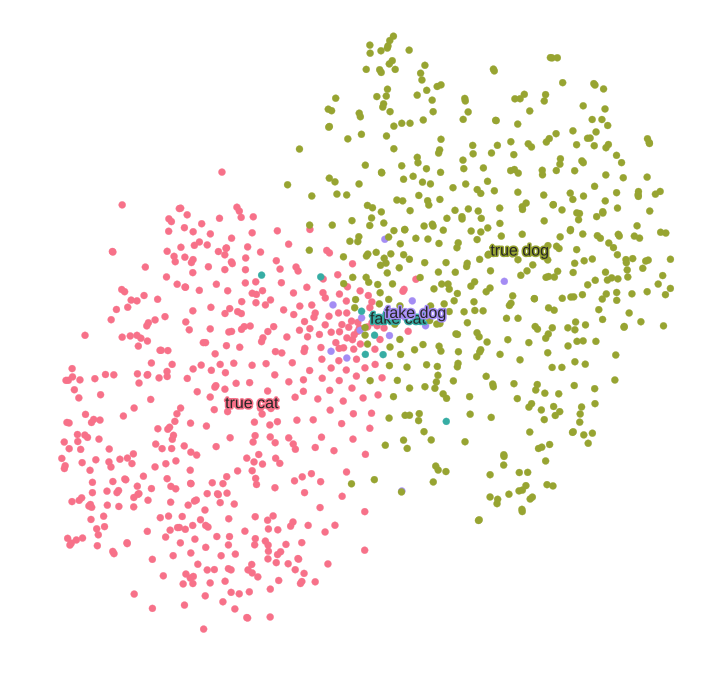

In [55]:
# visualize t-SNE output
data_scatter(fashion_tsne, classes)

### Different perplexity

t-SNE done! Time elapsed: 103.59072947502136 seconds


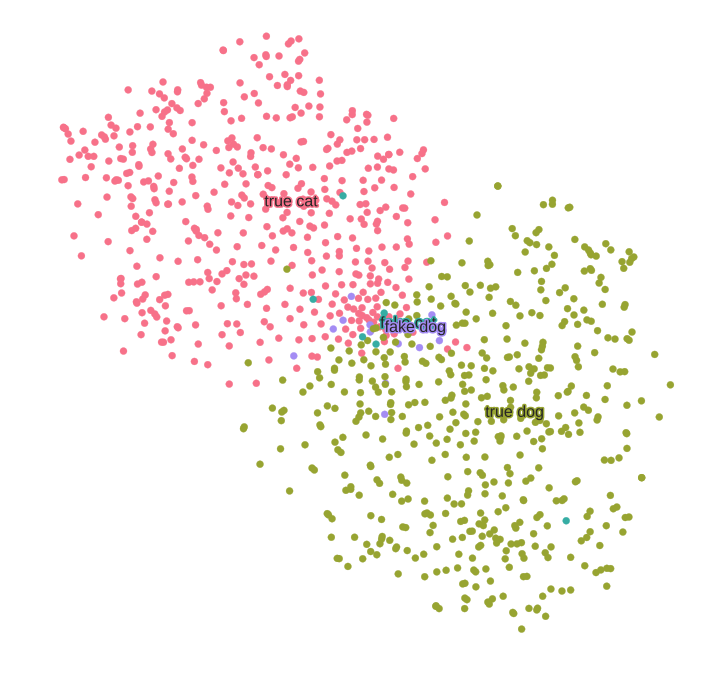

In [25]:
time_start = time.time()
fashion_tsne = TSNE(random_state=42, perplexity = 40).fit_transform(activations)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

data_scatter(fashion_tsne, classes)

##Conclusion

The convolutional layers do quite decent job separating dogs from cats. The "head" of the NN is able to find a natural border between the classes and also propery classify some outsiders. It might be overly aggressive in assuming cats as "outsider" dogs.